In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("titanic.csv")
df.head()

,target,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,5,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [4]:
df_label = df["target"]
label_classes = df_label.value_counts(ascending=True)
label_classes

1    342
0    549
Name: target, dtype: int64

In [5]:
label_classes.sum()

891

In [12]:
label_classes.count()
optimal_distribution = 1 / label_classes.count()
min_class_distribution = label_classes.values[0]/label_classes.sum()
min_class_distribution

0.3838383838383838

In [13]:
min_class_distribution/optimal_distribution

0.7676767676767676

In [1]:
!pip install fairlens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 948.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyemd: filename=pyemd-0.5.1-cp38-cp38-macosx_10_9_x86_64.whl size=76313 sha256=a990eaa5fa24d0e7163feaf500d05896e43580088dd9bee9b618339c59ef6c40
  Stored in directory: /Users/thandavm/Library/Caches/pip/wheels/a2/a5/34/f960a47ca5c06b0e91b6f48117a79a66f53a879f8fac9529bf
Successfully built pyemd
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.2
    Uninstalling scipy-1.5.2:
      Successfully uninstalled scipy-1.5.2
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.0
    Uninstalling seaborn-0.11.0:
      Successfully uninstalled se

In [5]:
import fairlens as fl

fl.FairnessScorer(df, "target").sensitive_attrs

fscorer = fl.FairnessScorer(df, "target", ["Age", "Sex"])

fscorer.distribution_score().aggregate
#fscorer.demographic_report()

,Group,Distance,Proportion,Counts
0,"Age [19.00, 22.00]",-0.100256,0.075196,67
1,"Age [36.00, 41.00]",-0.025348,0.059484,53
2,"Age [25.00, 28.00]",0.009604,0.068462,61
3,"Age [31.80, 36.00]",0.099678,0.102132,91
4,nan,-0.090053,0.198653,177
5,"Age [50.00, 80.00]",-0.040088,0.071829,64
6,"Age [0.42, 14.00]",0.200577,0.086420,77
7,"Age [28.00, 31.80]",0.010101,0.074074,66
8,"Age [14.00, 19.00]",0.006966,0.097643,87
9,"Age [41.00, 50.00]",0.013598,0.087542,78


In [7]:
sattrs = fl.FairnessScorer(df, "target").sensitive_attrs
len(sattrs)

2

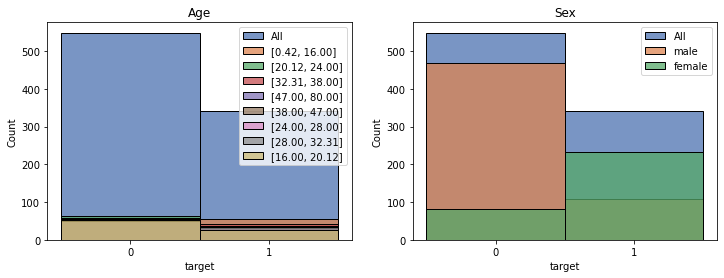

In [16]:
fscorer.plot_distributions()

In [14]:
fscorer.distribution_score(max_comb=1, p_value=True).sort_values("Distance", ascending=False).reset_index(drop=True)

,Group,Distance,Proportion,Counts,P-Value
0,female,0.358200,0.352413,314,6.876613e-38
1,"Age [0.42, 14.00]",0.200577,0.086420,77,3.934366e-04
2,"Age [31.80, 36.00]",0.099678,0.102132,91,5.285901e-02
3,"Age [41.00, 50.00]",0.013598,0.087542,78,8.165496e-01
4,"Age [28.00, 31.80]",0.010101,0.074074,66,8.995408e-01
5,"Age [25.00, 28.00]",0.009604,0.068462,61,8.956964e-01
6,"Age [14.00, 19.00]",0.006966,0.097643,87,9.124563e-01
7,"Age [22.00, 25.00]",-0.012410,0.078563,70,9.024669e-01
8,"Age [36.00, 41.00]",-0.025348,0.059484,53,7.784693e-01
9,"Age [50.00, 80.00]",-0.040088,0.071829,64,6.074709e-01


In [18]:
import fairlens.metrics as fm

fm.

AttributeError: module 'fairlens.metrics' has no attribute 'distribution_score'